In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
%matplotlib inline

In [2]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eventF1_df = pd.read_json('file:EventJson_F1.json')
eventM1_df = pd.read_json('file:EventJson_M1.json')
accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256

In [3]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])
    

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')
    print('length: ',T,' seconds')
    print('sample spacing: ',dt,' seconds')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(np.array(eeg))
        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [4]:
F1_time_vector,F1_eeg,F1_T = process_eeg_dataframe(eegF1_df)
M1_time_vector,M1_eeg,M1_T = process_eeg_dataframe(eegF1_df)

length:  296.4375  seconds
sample spacing:  0.046875  seconds
shape of channel  0 :  (75888,)
shape of channel  1 :  (75888,)
shape of channel  2 :  (75888,)
shape of channel  3 :  (75888,)
shape of channel  4 :  (75888,)
length:  296.4375  seconds
sample spacing:  0.046875  seconds
shape of channel  0 :  (75888,)
shape of channel  1 :  (75888,)
shape of channel  2 :  (75888,)
shape of channel  3 :  (75888,)
shape of channel  4 :  (75888,)


In [5]:
print(F1_time_vector.shape,F1_eeg.shape)

(75888,) (5, 75888)


In [6]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

In [7]:
def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [8]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]


In [9]:
import datetime
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

In [10]:
eventM1_df["timestamp"][0]

Timestamp('2019-07-25 22:40:22.979000')

In [11]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [12]:
def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

In [34]:
eventM1 = process_event_dataframe(eventM1_df,datetime_to_float(first_timestamp(eegM1_df)))
eventM1[1] = compute_EEG_indices(eventM1[1], fs)
eventM1

array([[8, 8, 5, 5, 6, 6, 10, 10, 8, 8, 7, 7, 49, 49, 29, 29, 39, 39, 9,
        9, 26, 26, 63, 63, 107, 107],
       [2885, 5761, 8656, 11536, 14416, 17304, 20184, 23075, 25955,
        28839, 31728, 34607, 37498, 40378, 43259, 46150, 49030, 51921,
        54802, 57685, 60573, 63453, 66344, 69225, 72105, 74996]],
      dtype=object)

In [15]:
F1_eeg[0]

array([20.99609375,  5.859375  ,  6.8359375 , ..., 19.04296875,
       24.4140625 , 21.97265625])

In [16]:
F1_T


296.4375

In [17]:
F1_time_vector

array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       2.96425781e+02, 2.96429688e+02, 2.96433594e+02])

In [18]:
first_stimulus = (first_timestamp(eventM1_df) - first_timestamp(eegM1_df))/np.timedelta64(1, 's')

In [19]:
first_stimulus

11.270625

In [20]:
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [21]:
first_stimulus_index = find_nearest(M1_time_vector, first_stimulus)

In [22]:
first_stimulus - M1_time_vector[2885]

0.0010937500000007816

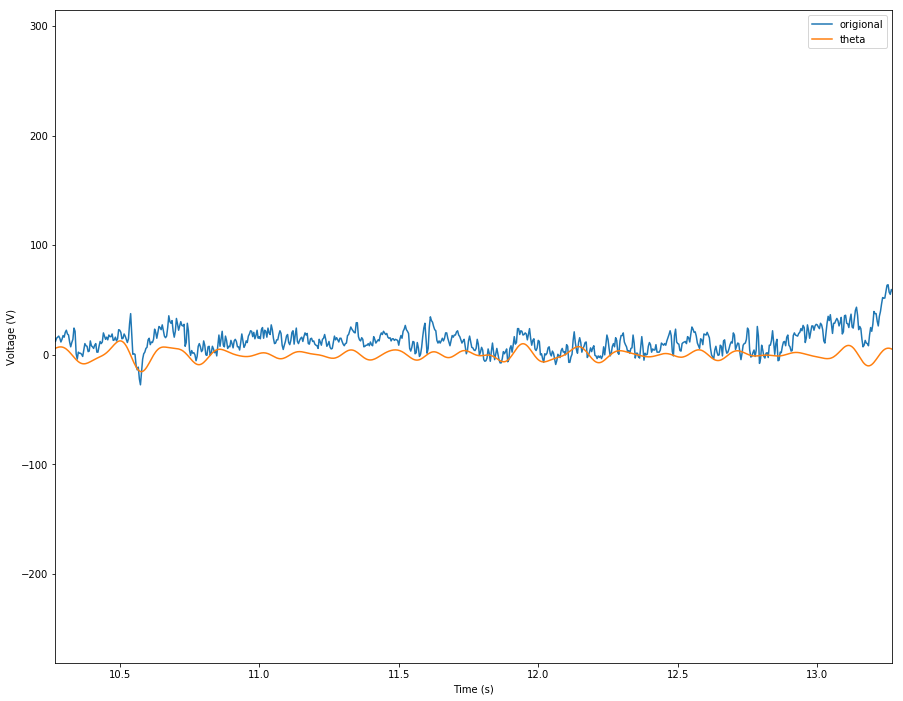

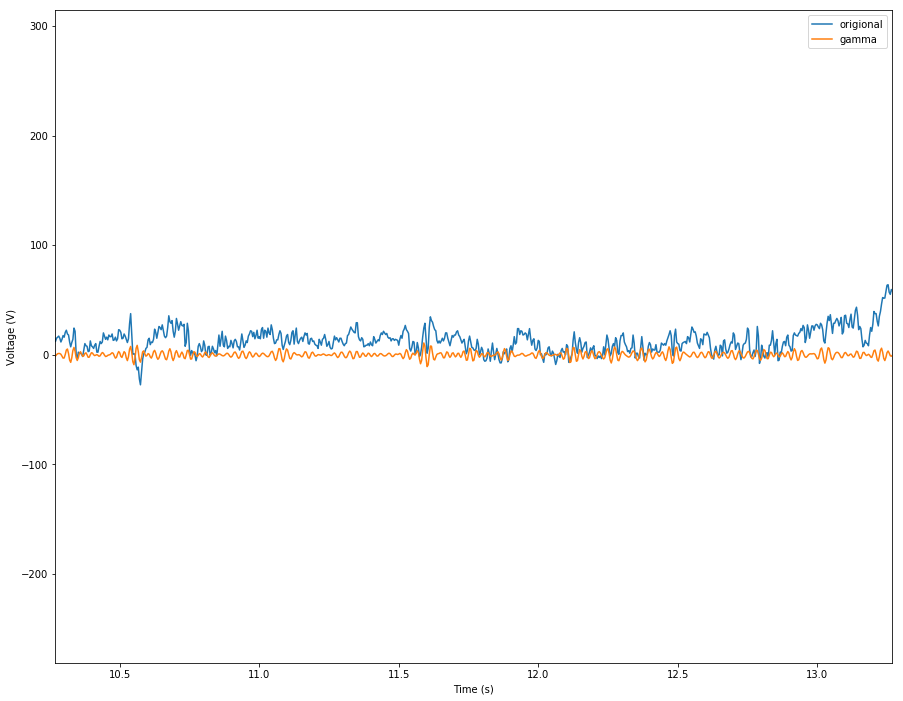

In [23]:
FIR_theta = signal.firwin(751, cutoff=(4,10), fs=fs, pass_zero=False)
theta_osc = np.empty(M1_eeg.shape)
theta_osc[0] = np.convolve(M1_eeg[0], FIR_theta, mode='same')
theta_osc[1] = np.convolve(M1_eeg[2], FIR_theta, mode='same')
theta_osc[2] = np.convolve(M1_eeg[2], FIR_theta, mode='same')
theta_osc[3] = np.convolve(M1_eeg[3], FIR_theta, mode='same')
theta_osc[4] = np.convolve(M1_eeg[4], FIR_theta, mode='same')

FIR_gamma = signal.firwin(251, cutoff=(30,50), fs=fs, pass_zero=False)
gamma_osc =  np.empty(M1_eeg.shape)
gamma_osc[0] = np.convolve(M1_eeg[0], FIR_gamma, mode='same')
gamma_osc[1] = np.convolve(M1_eeg[2], FIR_gamma, mode='same')
gamma_osc[2] = np.convolve(M1_eeg[2], FIR_gamma, mode='same')
gamma_osc[3] = np.convolve(M1_eeg[3], FIR_gamma, mode='same')
gamma_osc[4] = np.convolve(M1_eeg[4], FIR_gamma, mode='same')

t_vector = np.arange(0,len(M1_eeg[0])/fs,1/fs)

plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.plot(t_vector, F1_eeg[0], '-', label = "origional")
plt.plot(t_vector, theta_osc[0], '-', label = "theta")
plt.xlim([M1_time_vector[2885]-1,M1_time_vector[2885]+2])
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
plt.legend()

plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.plot(t_vector, M1_eeg[0], '-', label = "origional")
plt.plot(t_vector, gamma_osc[0], '-', label = "gamma")
plt.xlim(M1_time_vector[2885]-1,M1_time_vector[2885]+2)
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
plt.legend()



In [24]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

In [40]:
def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
        for value in data[start:end]:
            epoch.append(value - baseline)
        epoch_list.append(epoch)
    return np.array(epoch_list)

In [41]:
len_pre = -0.5
len_post = 1.5

In [42]:
epochs = list()
epochs.append(get_windows(M1_eeg[0], eventM1[1], fs, len_pre, len_post))
epochs.append(get_windows(M1_eeg[1], eventM1[1], fs, len_pre, len_post))
epochs.append(get_windows(M1_eeg[2], eventM1[1], fs, len_pre, len_post))
epochs.append(get_windows(M1_eeg[3], eventM1[1], fs, len_pre, len_post))
epochs.append(get_windows(M1_eeg[4], eventM1[1], fs, len_pre, len_post))
epochs = np.array(epochs)

In [43]:
epochs[0].shape

(26, 512)

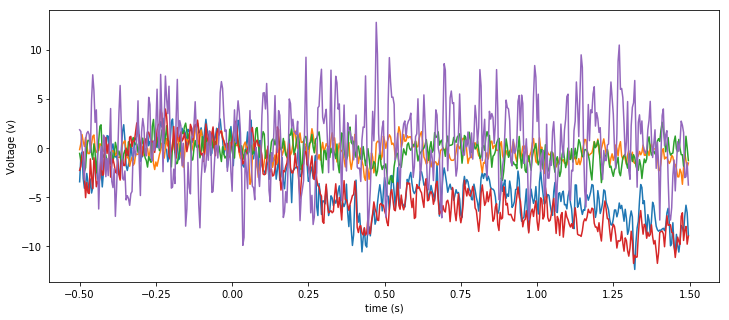

In [44]:
trial_average = list()
trial_average.append(np.mean(epochs[0], axis=0))
trial_average.append(np.mean(epochs[1], axis=0))
trial_average.append(np.mean(epochs[2], axis=0))
trial_average.append(np.mean(epochs[3], axis=0))
trial_average.append(np.mean(epochs[4], axis=0))
trial_average= np.array(trial_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)
# plot STA
plt.figure(figsize=(12,5))
plt.plot(epoch_time, trial_average[0], '-')
plt.plot(epoch_time, trial_average[1], '-')
plt.plot(epoch_time, trial_average[2], '-')
plt.plot(epoch_time, trial_average[3], '-')
plt.plot(epoch_time, trial_average[4], '-')

plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');


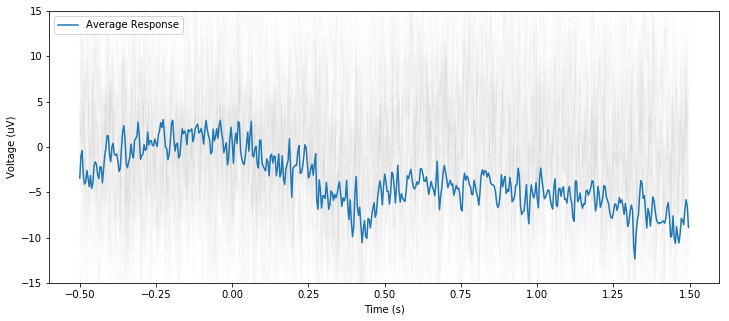

In [45]:
# plot all the epochs and average
plt.figure(figsize=(12,5))
plt.plot(epoch_time, epochs[0].T, '-k', alpha=0.01)
plt.plot(epoch_time, trial_average[0], label='Average Response')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.ylim([-15,15])
plt.legend()

In [46]:
catIndex = list()
snakeIndex = []
for i in range(0, len(eventM1[0])):
    if(eventM1[0][i] < 12):
        catIndex.append(eventM1[1][i])
    else:
        snakeIndex.append(eventM1[1][i])

In [49]:
epochs_cats = list()
epochs_cats.append(get_windows(M1_eeg[0], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M1_eeg[1], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M1_eeg[2], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M1_eeg[3], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M1_eeg[4], catIndex, fs, len_pre, len_post))
epochs_cats = np.array(epochs_cats)

epochs_snakes = list()
epochs_snakes.append(get_windows(M1_eeg[0], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M1_eeg[1], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M1_eeg[2], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M1_eeg[3], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M1_eeg[4], snakeIndex, fs, len_pre, len_post))
epochs_snakes = np.array(epochs_snakes)

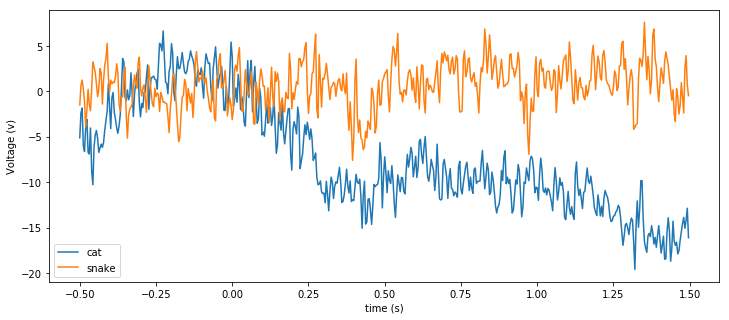

In [50]:
cat_average = list()
cat_average.append(np.mean(epochs_cats[0], axis=0))
cat_average.append(np.mean(epochs_cats[1], axis=0))
cat_average.append(np.mean(epochs_cats[2], axis=0))
cat_average.append(np.mean(epochs_cats[3], axis=0))
cat_average.append(np.mean(epochs_cats[4], axis=0))
cat_average= np.array(cat_average)

snake_average = list()
snake_average.append(np.mean(epochs_snakes[0], axis=0))
snake_average.append(np.mean(epochs_snakes[1], axis=0))
snake_average.append(np.mean(epochs_snakes[2], axis=0))
snake_average.append(np.mean(epochs_snakes[3], axis=0))
snake_average.append(np.mean(epochs_snakes[4], axis=0))
snake_average= np.array(snake_average)

# plot STA
plt.figure(figsize=(12,5))
plt.plot(epoch_time, cat_average[0], '-', label="cat")
plt.plot(epoch_time, snake_average[0], '-', label="snake")
#plt.plot(epoch_time, cat_average[1], '-')
#plt.plot(epoch_time, cat_average[2], '-')
#plt.plot(epoch_time, cat_average[3], '-')
#plt.plot(epoch_time, cat_average[4], '-')

plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
plt.legend()